## Dataset Overview: The Elliptic Bitcoin Dataset

The Elliptic Dataset is a graph network of Bitcoin transactions with handcrafted features.  
All features are constructed using only publicly available information.

### Transaction Classifications
The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:
- **Licit**: exchanges, wallet providers, miners, licit services, etc.
- **Illicit**: scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.

A given transaction is licit if the entity that generated it was licit.
- 2% are illicit (Class 1)  
- 21% are licit (Class 2)  
- 77% are unknown

### Features
Each node has associated 166 features:
- **94 local features**: timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures
- **72 aggregated features**: obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of neighbor transactions

### Temporal Information
A time step is associated with each node, representing the estimated time when the transaction is confirmed.  
There are 49 distinct timesteps evenly spaced with an interval of 2 weeks.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, 0 to 166
dtypes: float64(165), int64(2)
memory usage: 259.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB
Total columns: 167


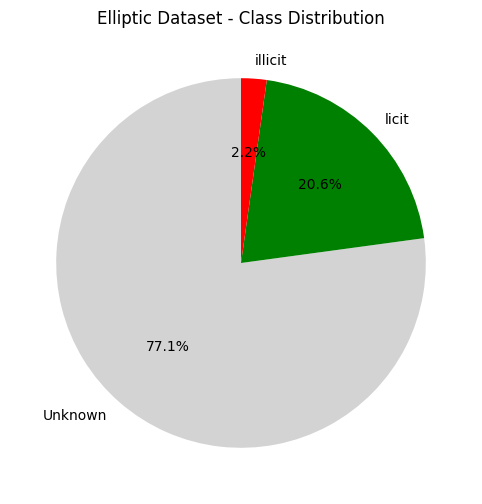

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
import networkx as nx
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

# Data Preparation
features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv',header=None)
classes = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
features.info()
classes.info()
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3)
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

# Apply to dataframe
features.rename(columns=colNames, inplace=True)

print(f"Total columns: {len(features.columns)}")

df = features.merge(classes, on='txId')

df.head()

features.head()
classes.head()

df.loc[df['class'] == 'unknown', 'class'] = 3
df['class'] = df['class'].astype(int)
df["class"].value_counts(normalize=True) * 100
df.dtypes
# 3   77.149 unknown
# 2   20.621 licit
# 1    2.230 illicit

labels = ['Unknown', 'licit', 'illicit']
sizes = [77149, 20621, 2230]
colors = ['lightgray', 'green', 'red']

# Simple pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Elliptic Dataset - Class Distribution')
plt.show()

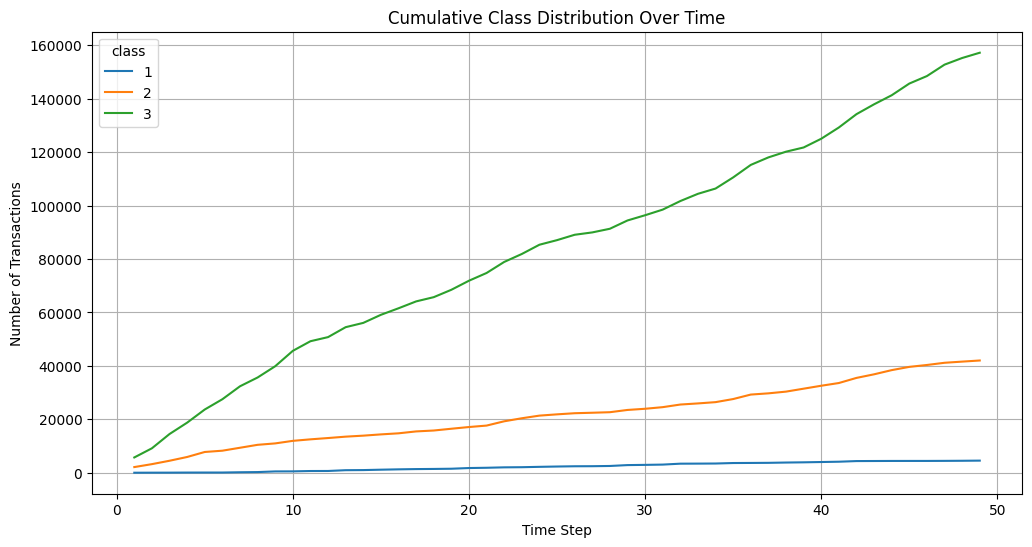

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 168 entries, txId to class
dtypes: float64(165), int64(3)
memory usage: 261.2 MB


txId                    False
Time step               False
Local_feature_1         False
Local_feature_2         False
Local_feature_3         False
                        ...  
Aggregate_feature_69    False
Aggregate_feature_70    False
Aggregate_feature_71    False
Aggregate_feature_72    False
class                   False
Length: 168, dtype: bool

In [2]:
# Time step analysis
df.groupby(['Time step', 'class']).size().unstack(fill_value=0).cumsum().plot(figsize=(12,6))
plt.title("Cumulative Class Distribution Over Time")
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

df.info()

df.isnull().any()

In [3]:
# Outlier handling
# ✅ Bitcoin whale transactions are expected and not removed

labeled_df = df[df['class'].isin([1, 2])].copy()
feature_cols = labeled_df.select_dtypes(include=['float64']).columns
labeled_df.head()
df['class'].unique()

# Exploratory Data Analysis
print("=== EXPLORATORY DATA ANALYSIS ===")
print(f"Labeled dataframe shape: {labeled_df.shape}")
print(f"Feature columns count: {len(feature_cols)}")
print(f"NaN values check:")
print(labeled_df[feature_cols].isnull().sum().sum()) 

labeled_df["class"].head()

# Feature scaling using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(labeled_df[feature_cols])

df_final = pd.DataFrame(X_scaled, columns=feature_cols, index=labeled_df.index)
df_final['class'] = labeled_df['class']
df_final['txId'] = labeled_df['txId']
df_final['Time step'] = labeled_df['Time step']
df_final['class'] = df_final['class'].map({2: 0, 1: 1})  # 0: licit, 1: illicit
df_final.head()

df_final["class"].value_counts()

# Process unknown data with the same scaler
unknown_df = df[df['class'] == 3].copy()
X_unknown_scaled = scaler.transform(unknown_df[feature_cols])

# Unknown DataFrame preparation
df_unknown = pd.DataFrame(X_unknown_scaled, columns=feature_cols, index=unknown_df.index)
df_unknown['txId'] = unknown_df['txId']
df_unknown['Time step'] = unknown_df['Time step']
df_unknown['class'] = 3  # Keep original class
df_unknown.head()

print(f"✅ Labeled scaled shape: {df_final.shape}")
print(f"✅ Unknown scaled shape: {df_unknown.shape}")

=== EXPLORATORY DATA ANALYSIS ===
Labeled dataframe shape: (46564, 168)
Feature columns count: 165
NaN values check:
0
✅ Labeled scaled shape: (46564, 168)
✅ Unknown scaled shape: (157205, 168)


In [4]:
# Feature Importance Analysis using Statistical Tests
print("\n=== FEATURE IMPORTANCE (T-TEST) ===")
feature_importance = []

for feature in feature_cols:
    illicit_vals = df_final[df_final['class'] == 1][feature]
    licit_vals = df_final[df_final['class'] == 0][feature]

    if len(illicit_vals) > 0 and len(licit_vals) > 0:
        t_stat, p_value = ttest_ind(illicit_vals, licit_vals)
        feature_importance.append({
            'feature': feature,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'difference': abs(illicit_vals.mean() - licit_vals.mean())
        })

importance_df = pd.DataFrame(feature_importance)
importance_df = importance_df.sort_values('p_value')
print("Most significant features (by p-value):")
print(importance_df.head(50))

# ⚡ p-value = 0.000 means:
# Features are statistically significant
# There's a real difference between the two groups
# The model can learn these differences

print(f"Total features: {len(importance_df)}")
print(f"Significant features: {importance_df['significant'].sum()}")
print(f"Non-significant features: {(~importance_df['significant']).sum()}")


=== FEATURE IMPORTANCE (T-TEST) ===
Most significant features (by p-value):
                  feature  p_value  significant  difference
90       Local_feature_91    0.000         True       0.439
54       Local_feature_55    0.000         True       0.567
52       Local_feature_53    0.000         True       0.551
149  Aggregate_feature_57    0.000         True       0.337
88       Local_feature_89    0.000         True       0.441
89       Local_feature_90    0.000         True       0.591
141  Aggregate_feature_49    0.000         True       5.143
51       Local_feature_52    0.000         True       0.641
153  Aggregate_feature_61    0.000         True       6.731
53       Local_feature_54    0.000         True       1.027
113  Aggregate_feature_21    0.000         True       0.524
147  Aggregate_feature_55    0.000         True       0.217
155  Aggregate_feature_63    0.000         True       0.595
82       Local_feature_83    0.000         True       1.215
84       Local_feature_

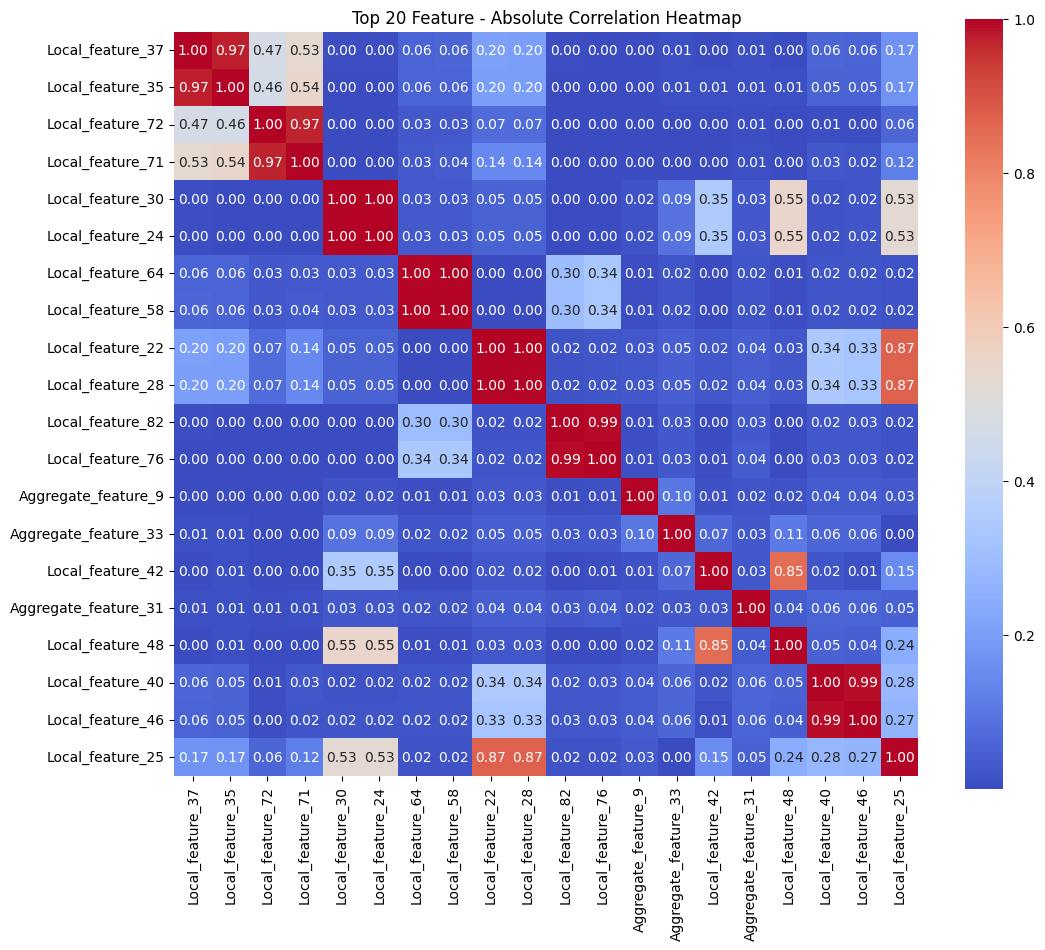

In [5]:
# Correlation Heatmap
top_features = importance_df.sort_values(["significant", "difference"], ascending=[False, False])\
                            .head(20)["feature"].tolist()

corr_matrix = df_final[top_features].corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Top 20 Feature - Absolute Correlation Heatmap")
plt.show()

# Analysis note: "In correlation analysis, high correlation was not observed among significant features.
# This indicates the presence of various independent signals that the model can learn,
# while also revealing that the risk of multicollinearity is low.
# Therefore, all features can be directly included in the model."

Fitting 5 folds for each of 24 candidates, totalling 120 fits
F1Score: 0.7804837740926056
ROC_AUC: 0.9762281505092864


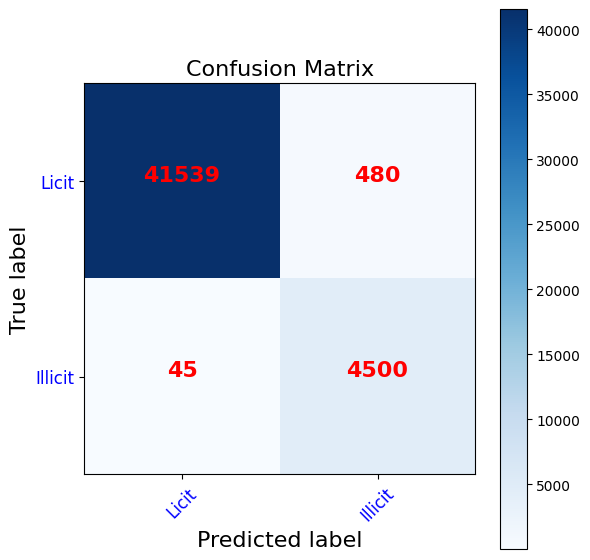

In [6]:
# XGBoost Model Training
X = df_final.drop(['class', 'txId', 'Time step'], axis=1)
y = df_final['class']

# Handle class imbalance: scale_pos_weight = licit/illicit ≈ 9.25
xgboost_model = XGBClassifier(random_state=17, eval_metric='logloss', scale_pos_weight=9.25)
xgboost_model.get_params()

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200, 500],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

# Best params: 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

# Cross-validation results
cv_results = cross_validate(xgboost_final, X, y, cv=5, n_jobs=-1, scoring=["f1", "roc_auc"])

print(f"F1Score: {(cv_results['test_f1']).mean()}")  # F1Score: 0.779
print(f"ROC_AUC: {(cv_results['test_roc_auc']).mean()}")  # ROC_AUC: 0.977

# Confusion Matrix
y_pred = xgboost_final.predict(X)
cm = confusion_matrix(y, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'size': 16})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, color="blue")
    plt.yticks(tick_marks, classes, fontsize=12, color="blue")

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),  # 'd' = integer
                 horizontalalignment="center",
                 color="red", fontsize=16, weight='bold')

    plt.ylabel('True label', fontdict={'size': 16})
    plt.xlabel('Predicted label', fontdict={'size': 16})
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Licit','Illicit'],
                      title='Confusion Matrix')

# Results interpretation:
# True Positive (TP) = 4,498
# False Negative (FN) = 47 → Main focus for improvement
# False Positive (FP) = 499 
# True Negative (TN) = 41,520

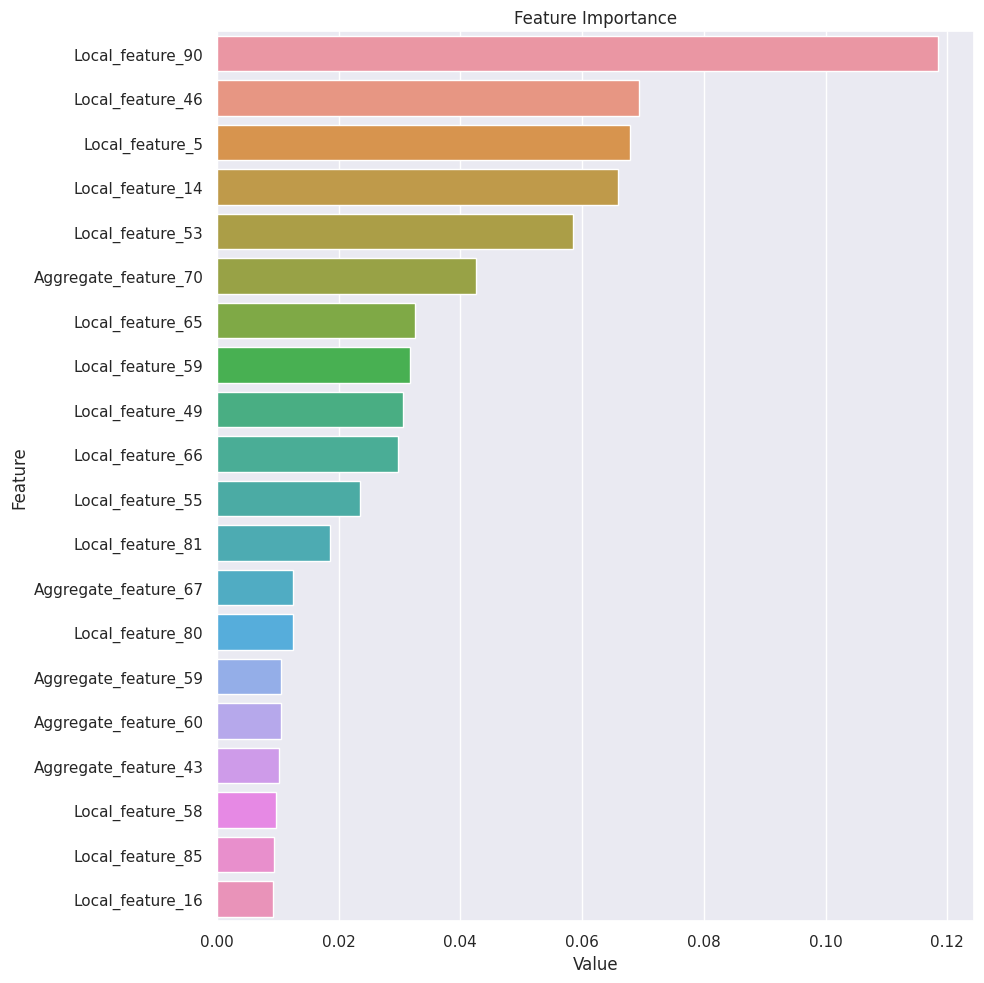

In [7]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(xgboost_final, X, num=20)

In [8]:
# Unknown Transaction Risk Assessment
print("\n=== UNKNOWN TRANSACTION RISK ASSESSMENT ===")

X_unknown = df_unknown.drop(['class', 'txId', 'Time step'], axis=1)
unknown_proba = xgboost_final.predict_proba(X_unknown)

# Add risk scores to unknown transactions
df_unknown['licit_prob'] = unknown_proba[:, 0]
df_unknown['illicit_prob'] = unknown_proba[:, 1]
df_unknown['risk_level'] = pd.cut(
    unknown_proba[:, 1],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Safe', 'Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True)

print("Risk level distribution (%):")
print(df_unknown["risk_level"].value_counts(normalize=True) * 100)

# Critical findings
high_risk_count = (df_unknown['illicit_prob'] >= 0.8).sum()
medium_high_risk_count = (df_unknown['illicit_prob'] >= 0.5).sum()

print(f"\n=== CRITICAL FINDINGS ===")
print(f"🚨 High Risk (≥80%): {high_risk_count:,} transactions")
print(f"⚠️ Medium Risk (≥50%): {medium_high_risk_count:,} transactions")
print(f"📊 Safe transactions (<20%): {(df_unknown['illicit_prob'] < 0.2).sum():,}")

print(f"\n=== ACTIONABLE RECOMMENDATIONS ===")
print(f"🎯 Immediate Action Required:")
print(f"   - Investigate {high_risk_count:,} high-risk transactions (≥80% probability)")
print(f"   - Review {medium_high_risk_count - high_risk_count:,} medium-risk transactions (50-80%)")

# Export high-risk transactions for investigation
high_risk_transactions = df_unknown[df_unknown['illicit_prob'] >= 0.8].copy()
print(f"\n=== EXPORT RECOMMENDATIONS ===")
print(f"high_risk_transactions.to_csv('high_risk_transactions.csv', index=False)")
print(f"This file contains {len(high_risk_transactions):,} transactions requiring immediate investigation")

print(f"\n✅ Analysis Complete!")
print(f"Your model successfully categorized {len(df_unknown):,} unknown transactions")


=== UNKNOWN TRANSACTION RISK ASSESSMENT ===
Risk level distribution (%):
risk_level
Safe          74.204
Low Risk      15.037
Medium Risk    6.148
High Risk      4.611
Name: proportion, dtype: float64

=== CRITICAL FINDINGS ===
🚨 High Risk (≥80%): 7,249 transactions
⚠️ Medium Risk (≥50%): 16,914 transactions
📊 Safe transactions (<20%): 116,652

=== ACTIONABLE RECOMMENDATIONS ===
🎯 Immediate Action Required:
   - Investigate 7,249 high-risk transactions (≥80% probability)
   - Review 9,665 medium-risk transactions (50-80%)

=== EXPORT RECOMMENDATIONS ===
high_risk_transactions.to_csv('high_risk_transactions.csv', index=False)
This file contains 7,249 transactions requiring immediate investigation

✅ Analysis Complete!
Your model successfully categorized 157,205 unknown transactions



=== NETWORK ANALYSIS ===
Total edges in dataset: 234,355
High-risk transactions: 7,249
Connected edges: 13,430
Unique neighbors found: 12,168
Analyzed neighbors: 8,724
Neighbor risk distribution:
risk_level
Safe     0.492
High     0.218
Low      0.181
Medium   0.109
Name: proportion, dtype: float64


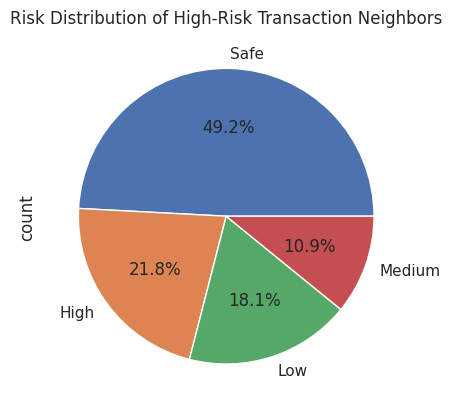

In [9]:
# Network Analysis - Suspicious Transaction Connections
print("\n=== NETWORK ANALYSIS ===")

df_edges = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
print(f"Total edges in dataset: {len(df_edges):,}")

high_risk_ids = high_risk_transactions['txId'].tolist()
print(f"High-risk transactions: {len(high_risk_ids):,}")

# Find connections involving high-risk transactions
connected_edges = df_edges[(df_edges['txId1'].isin(high_risk_ids)) | (df_edges['txId2'].isin(high_risk_ids))]
print(f"Connected edges: {len(connected_edges):,}")

# Extract neighbors of high-risk transactions
outgoing = df_edges[df_edges['txId1'].isin(high_risk_ids)]['txId2']
incoming = df_edges[df_edges['txId2'].isin(high_risk_ids)]['txId1']
all_neighbors = pd.concat([outgoing, incoming]).unique()
print(f"Unique neighbors found: {len(all_neighbors):,}")

# Analyze neighbor risk scores
neighbor_risks = []
for neighbor_id in all_neighbors:
    if neighbor_id in df_unknown['txId'].values:
        risk_score = df_unknown[df_unknown['txId'] == neighbor_id]['illicit_prob'].iloc[0]
        neighbor_risks.append({
             'txId': neighbor_id,
             'illicit_prob': risk_score,
             'risk_level': 'High' if risk_score >= 0.8 else
                          'Medium' if risk_score >= 0.5 else
                          'Low' if risk_score >= 0.2 else 'Safe'})

neighbor_risk_df = pd.DataFrame(neighbor_risks)
print(f"Analyzed neighbors: {len(neighbor_risk_df):,}")
print("Neighbor risk distribution:")
print(neighbor_risk_df['risk_level'].value_counts(normalize=True))

# Visualize neighbor risk distribution
neighbor_risk_df['risk_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Risk Distribution of High-Risk Transaction Neighbors')
plt.show()


=== NETWORK VISUALIZATION ===


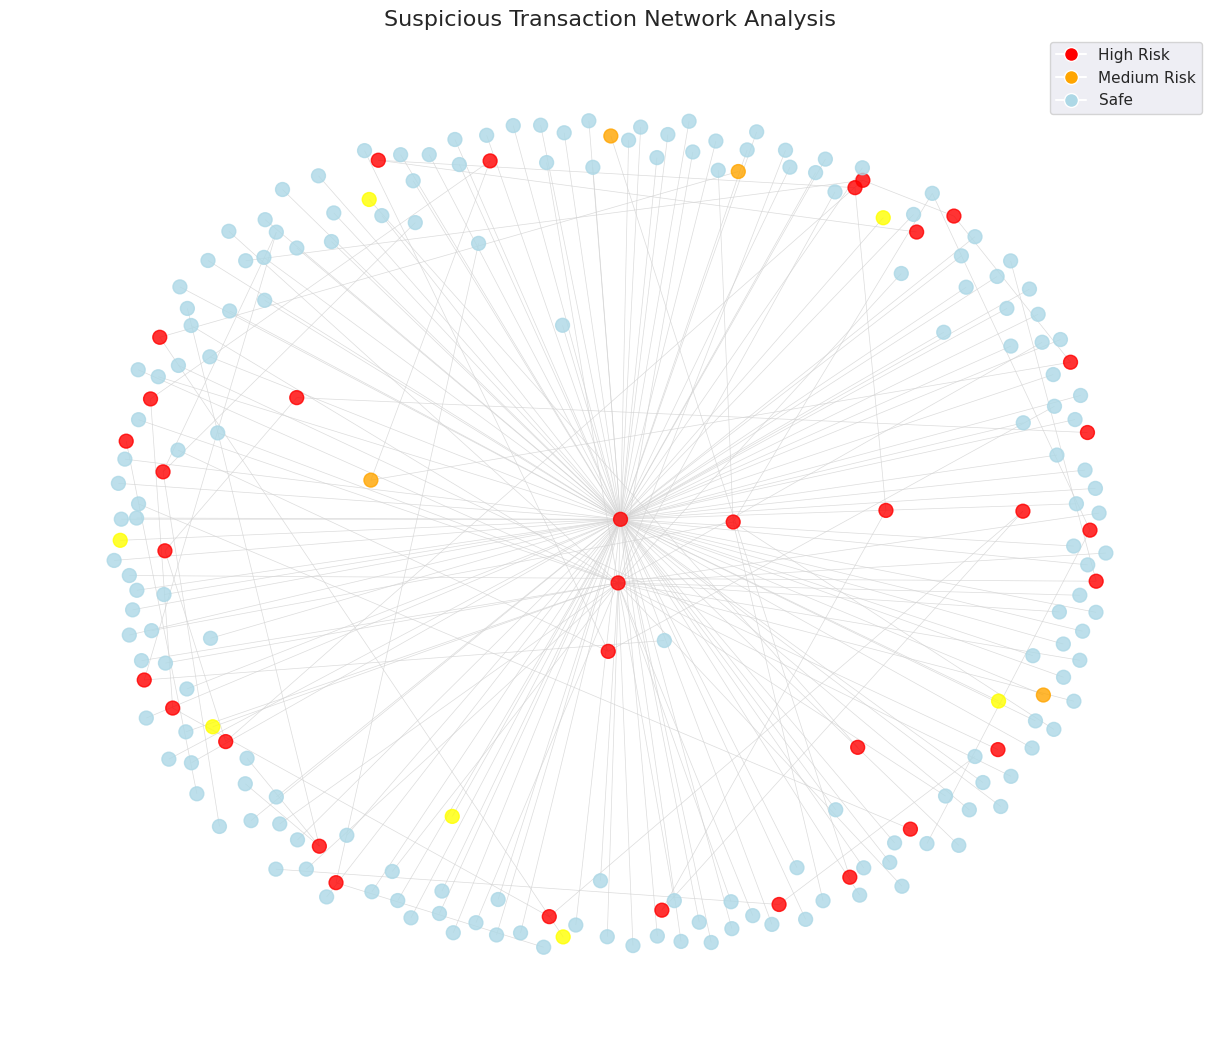


🎯 NETWORK ANALYSIS CONCLUSIONS:
- High-risk transactions form interconnected clusters
- Many neighbors of high-risk transactions also show elevated risk scores
- Network analysis reveals potential money laundering rings
- This graph-based approach enhances traditional ML predictions


In [10]:
# Network visualization of suspicious connections
print("\n=== NETWORK VISUALIZATION ===")

# Create subset for visualization (limit to 200 edges for performance)
high_risk_neighbor_edges = df_edges[
    (df_edges['txId1'].isin(high_risk_ids) & df_edges['txId2'].isin(neighbor_risk_df['txId'])) |
    (df_edges['txId2'].isin(high_risk_ids) & df_edges['txId1'].isin(neighbor_risk_df['txId']))].head(200)

G = nx.from_pandas_edgelist(high_risk_neighbor_edges,
                           source='txId1', target='txId2')

# Assign node colors based on risk levels
node_colors = []
for node in G.nodes():
    if node in high_risk_ids:
        node_colors.append('red')  # Original high-risk transactions
    else:
        # Get risk level from neighbor analysis
        if node in neighbor_risk_df['txId'].values:
            risk_level = neighbor_risk_df[neighbor_risk_df['txId'] == node]['risk_level'].iloc[0]
            if risk_level == 'High':
                node_colors.append('darkred')
            elif risk_level == 'Medium':
                node_colors.append('orange')
            elif risk_level == 'Low':
                node_colors.append('yellow')
            else:  # Safe
                node_colors.append('lightblue')
        else:
            node_colors.append('gray')

# Create network layout
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw the network
plt.figure(figsize=(12, 10))
nx.draw(G, pos=pos,
       node_color=node_colors,
       node_size=100,  
       alpha=0.8,      
       edge_color='lightgray', 
       width=0.5,      
       with_labels=False)

# Add legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Risk')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Safe')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Risk')

plt.legend(handles=[red_patch, orange_patch, blue_patch])
plt.title("Suspicious Transaction Network Analysis", fontsize=16)
plt.axis('off')  
plt.tight_layout()
plt.show()

print("\n🎯 NETWORK ANALYSIS CONCLUSIONS:")
print("- High-risk transactions form interconnected clusters")
print("- Many neighbors of high-risk transactions also show elevated risk scores")
print("- Network analysis reveals potential money laundering rings")
print("- This graph-based approach enhances traditional ML predictions")

**FINAL RESULTS & IMPACT**


The developed model successfully identified high-risk transactions from 157,205 unknown transactions


Organized crime network connections have been revealed


The risk of missing illicit transactions has been minimized

